In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from math import ceil
from statistics import mean
#################################
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, inp, tgt, device='cpu'):
        'Initialization'
        self.inp = to_device(torch.from_numpy(inp).float(), device)
        self.tgt = to_device(torch.from_numpy(tgt).float(), device)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tgt)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.inp[index], self.tgt[index]

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(11, 50)   # hidden layer
        self.drop1 = torch.nn.Dropout(p=0.2)
        self.hidden2 = torch.nn.Linear(50, 50)   # hidden layer
        self.drop2 = torch.nn.Dropout(p=0.2)
        self.hidden3 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden4 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden5 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden6 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden7 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden8 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden9 = torch.nn.Linear(50, 50)   # hidden layer
        self.predict = torch.nn.Linear(50, 6)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.drop1(x))
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = F.relu(self.drop2(x))
        x = F.relu(self.hidden3(x))      # activation function for hidden layer
#         x = F.relu(self.hidden4(x))      # activation function for hidden layer
#         x = F.relu(self.hidden5(x))      # activation function for hidden layer
#         x = F.relu(self.hidden6(x))      # activation function for hidden layer
#         x = F.relu(self.hidden7(x))      # activation function for hidden layer
#         x = F.relu(self.hidden8(x))      # activation function for hidden layer
#         x = F.relu(self.hidden9(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
torch.manual_seed(42)

In [5]:
%%time

train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/train.pkl")
ref_train, X_train, y_train = get_ref_X_y(train_df)

X_min_max_scaler = MinMaxScaler()
y_min_max_scaler = MinMaxScaler()

X_train = X_min_max_scaler.fit_transform(X_train)
y_train = y_min_max_scaler.fit_transform(y_train)

test_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/test.pkl")
ref_test, X_test, y_test = get_ref_X_y(test_df)

X_test = X_min_max_scaler.fit_transform(X_test)
y_test = y_min_max_scaler.fit_transform(y_test)

In [69]:
params = {
    'batch_size': 250000,
#     'shuffle': True,
    'num_workers': 4,
}

training_set = Dataset(X_train, y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

testing_set = Dataset(X_test, y_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

In [26]:
sample_train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_train.pkl")
sample_ref_train, sample_X_train, sample_y_train = get_ref_X_y(sample_train_df)

sample_X_min_max_scaler = MinMaxScaler()
sample_y_min_max_scaler = MinMaxScaler()

sample_X_train = sample_X_min_max_scaler.fit_transform(sample_X_train)
sample_y_train = sample_y_min_max_scaler.fit_transform(sample_y_train)

sample_test_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_test.pkl")
sample_ref_test, sample_X_test, sample_y_test = get_ref_X_y(sample_test_df)

sample_X_test = sample_X_min_max_scaler.fit_transform(sample_X_test)
sample_y_test = sample_y_min_max_scaler.fit_transform(sample_y_test)

params = {
    'batch_size': 10000,
#     'shuffle': True,
}

training_set = Dataset(sample_X_train, sample_y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

testing_set = Dataset(sample_X_test, sample_y_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

(-0.1, 0.1)

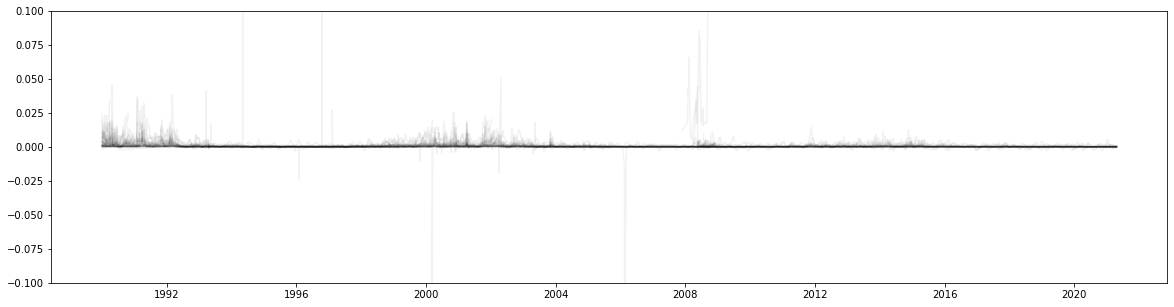

In [39]:
fig,ax = plt.subplots(figsize=(20,5))
for norad_id, df1 in sample_train_df.groupby("__NORAD_CAT_ID"):
    df1 = df1.set_index("__EPOCH_1").sort_index()
    df2 = df1[~df1.index.duplicated()][['X_BSTAR']]
#     display(df2)
    oidx = df2.index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq='1D')
    res = df2.reindex(oidx.union(nidx)).interpolate('index').reindex(nidx)
#     display(res)
#     ax.plot(res.index, res['INCLINATION'].diff())
    ax.plot(res.index, (res['X_BSTAR']), alpha=0.05, color="black")
ax.set_ylim([-0.1, 0.1])

In [5]:
sample_train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_train.pkl")
sample_ref_train, sample_X_train, sample_y_train = get_ref_X_y(sample_train_df)


In [6]:
sample_train_df

,__NORAD_CAT_ID,__GP_ID_1,__GP_ID_2,__EPOCH_1,__EPOCH_2,X_EPOCH_JD,X_EPOCH_FR,X_BSTAR,X_INCLINATION,X_RA_OF_ASC_NODE,...,X_MEAN_ANOMALY,X_MEAN_MOTION,X_REV_AT_EPOCH,X_delta_EPOCH,y_delta_INCLINATION,y_delta_ECCENTRICITY,y_delta_MEAN_MOTION,y_delta_ARG_OF_PERICENTER,y_delta_RA_OF_ASC_NODE,y_delta_REV_MEAN_ANOMALY_COMBINED
0,132,44161820,17172138,1990-01-01 15:35:27.839327,1990-01-02 05:22:53.882399,2447892.5,0.649628,0.000357,66.6549,71.6048,...,193.7330,13.924451,44853,0.574607,-0.0001,0.000002,0.000007,-0.3599,-1.4149,2880.3679
1,132,17172138,44161821,1990-01-02 05:22:53.882399,1990-01-02 15:43:28.328736,2447893.5,0.224235,0.000364,66.6548,70.1899,...,194.1009,13.924458,44861,0.430954,-0.0001,-0.000012,0.000006,-0.3326,-1.0614,2160.3343
2,132,44161821,44161822,1990-01-02 15:43:28.328736,1990-01-03 14:08:03.044832,2447893.5,0.655189,0.000370,66.6547,69.1285,...,194.4352,13.924464,44867,0.933735,-0.0002,-0.000007,0.000011,-0.6569,-2.2994,4680.6674
3,132,44161822,44161823,1990-01-03 14:08:03.044832,1990-01-04 14:16:03.416735,2447894.5,0.588924,0.000378,66.6545,66.8291,...,195.1026,13.924475,44880,1.005560,-0.0001,-0.000009,0.000011,-0.6822,-2.4759,5040.6910
4,132,44161823,44161824,1990-01-04 14:16:03.416735,1990-01-08 04:27:30.277439,2447895.5,0.594484,0.000383,66.6544,64.3532,...,195.7936,13.924487,44894,3.591283,0.0005,-0.000029,0.000029,-2.4657,-8.8418,18002.4983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2749051,47108,174008116,174333927,2021-03-23 16:55:08.131872,2021-03-28 09:28:02.771328,2459296.5,0.704955,0.000102,65.8171,235.8334,...,28.6323,12.368879,5505,4.689521,0.0006,0.000015,0.000023,-1.8353,-9.3271,20881.4924
2749052,47108,175507345,175794796,2021-04-15 12:08:08.938464,2021-04-19 20:55:16.877568,2459319.5,0.505659,0.000200,65.8183,190.4836,...,35.9553,12.369008,5787,4.366064,0.0003,0.000005,0.000042,-1.7043,-8.6831,19441.4182
2749053,47108,175587347,175831854,2021-04-16 11:25:17.467104,2021-04-20 14:23:08.102112,2459320.5,0.475897,0.000199,65.8188,188.5546,...,36.2685,12.369016,5799,4.123503,-0.0002,0.000008,0.000040,-1.6129,-8.2014,18361.3431
2749054,47108,167960096,168246710,2020-12-17 11:41:30.668064,2020-12-22 04:14:44.020896,2459200.5,0.487161,0.000157,65.8200,67.1591,...,358.9169,12.368271,4315,4.689738,0.0001,0.000023,0.000029,-1.8464,-9.3223,20521.4389


In [7]:
sample_X_train

,X_EPOCH_JD,X_EPOCH_FR,X_BSTAR,X_INCLINATION,X_RA_OF_ASC_NODE,X_ECCENTRICITY,X_ARG_OF_PERICENTER,X_MEAN_ANOMALY,X_MEAN_MOTION,X_REV_AT_EPOCH,X_delta_EPOCH
0,2447892.5,0.649628,0.000357,66.6549,71.6048,0.007553,166.5784,193.7330,13.924451,44853,0.574607
1,2447893.5,0.224235,0.000364,66.6548,70.1899,0.007555,166.2185,194.1009,13.924458,44861,0.430954
2,2447893.5,0.655189,0.000370,66.6547,69.1285,0.007544,165.8859,194.4352,13.924464,44867,0.933735
3,2447894.5,0.588924,0.000378,66.6545,66.8291,0.007537,165.2290,195.1026,13.924475,44880,1.005560
4,2447895.5,0.594484,0.000383,66.6544,64.3532,0.007528,164.5468,195.7936,13.924487,44894,3.591283
...,...,...,...,...,...,...,...,...,...,...,...
2749051,2459296.5,0.704955,0.000102,65.8171,235.8334,0.120965,323.8435,28.6323,12.368879,5505,4.689521
2749052,2459319.5,0.505659,0.000200,65.8183,190.4836,0.121045,314.9158,35.9553,12.369008,5787,4.366064
2749053,2459320.5,0.475897,0.000199,65.8188,188.5546,0.121044,314.5389,36.2685,12.369016,5799,4.123503
2749054,2459200.5,0.487161,0.000157,65.8200,67.1591,0.120438,1.4940,358.9169,12.368271,4315,4.689738


In [8]:
sample_y_train

,y_delta_INCLINATION,y_delta_ECCENTRICITY,y_delta_MEAN_MOTION,y_delta_ARG_OF_PERICENTER,y_delta_RA_OF_ASC_NODE,y_delta_REV_MEAN_ANOMALY_COMBINED
0,-0.0001,0.000002,0.000007,-0.3599,-1.4149,2880.3679
1,-0.0001,-0.000012,0.000006,-0.3326,-1.0614,2160.3343
2,-0.0002,-0.000007,0.000011,-0.6569,-2.2994,4680.6674
3,-0.0001,-0.000009,0.000011,-0.6822,-2.4759,5040.6910
4,0.0005,-0.000029,0.000029,-2.4657,-8.8418,18002.4983
...,...,...,...,...,...,...
2749051,0.0006,0.000015,0.000023,-1.8353,-9.3271,20881.4924
2749052,0.0003,0.000005,0.000042,-1.7043,-8.6831,19441.4182
2749053,-0.0002,0.000008,0.000040,-1.6129,-8.2014,18361.3431
2749054,0.0001,0.000023,0.000029,-1.8464,-9.3223,20521.4389


In [ ]:
net = Net() # define the network
print(net)  # net architecture
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

start_time = time()
num_batches = ceil(len(training_set)/params['batch_size'])
lr = 1
decay = 0.99
losses = []
max_epochs = 5
# train the network

optimizer = torch.optim.SGD(net.parameters(), lr=lr)

epbar = tqdm(range(max_epochs))

for epoch in epbar:
    epbar.set_description(f"Epoch {epoch+1}")

    elosses = []
    vlosses = []
    etime = time()

    ipbar = tqdm(training_generator, leave=False)
    ipbar.set_description(f"Training LR: {lr:.4f}")
    
    for i, (x, y) in enumerate(ipbar):
        itime = time()
        optimizer.zero_grad()
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        elosses.append(loss.data.numpy().item())
        ipbar.set_postfix({'loss': loss.data.numpy()})

    with torch.set_grad_enabled(False):
        vpbar = tqdm(testing_generator, leave=False)
        vpbar.set_description("Validating")
        for i, (x, y) in enumerate(vpbar):
            prediction = net(x)     # input x and predict based on x
            loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
            vlosses.append(loss.data.numpy().item())
    mean_elosses = mean(elosses)
    mean_vlosses = mean(vlosses)
    losses.append((mean_elosses, mean_vlosses))
    
    epbar.set_postfix({'train_loss':f"{mean_elosses:.9f}", 'val_loss':f"{mean_vlosses:.9f}"})
    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    lr = lr*decay

Net(
  (hidden1): Linear(in_features=11, out_features=50, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (drop2): Dropout(p=0.2, inplace=False)
  (hidden3): Linear(in_features=50, out_features=50, bias=True)
  (predict): Linear(in_features=50, out_features=6, bias=True)
)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1088 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/1088 [00:00<?, ?it/s]

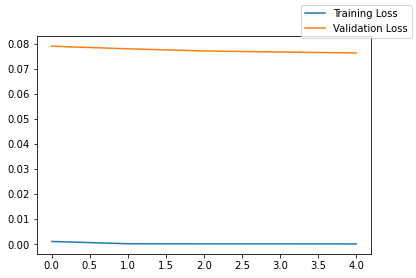

In [61]:
tl, vl = zip(*losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [ ]:
# torch.save(net,"testing_model.pt")